In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# img_rows, img_cols, channels = 224, 224, 3

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

# Helper function to extract the least likely label from probability vector
def get_least_likely_imagenet_label(probs):
  return decode_predictions(probs, top=1000)[0][999]


14540800/14536120 [==============================] - 0s 0us/step


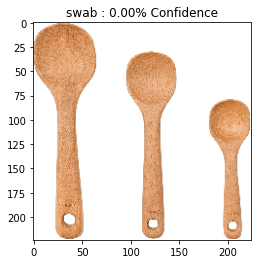

In [49]:
import cv2
import numpy as np

image = cv2.imread('wooden spoon910.jpg')
image = np.flip(image, axis=2)

image = preprocess(image)
image_probs = pretrained_model.predict(image)


plt.figure()
plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
_, ll_image_class, ll_class_confidence = get_least_likely_imagenet_label(image_probs)

plt.title('{} : {:.2f}% Confidence'.format(ll_image_class, ll_class_confidence*100))
plt.show()

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_ll_adversarial_pattern(input_image, input_ll_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_ll_label, prediction)


  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

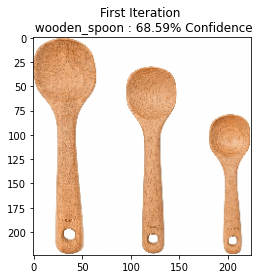

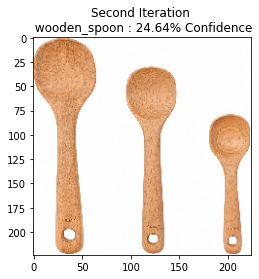

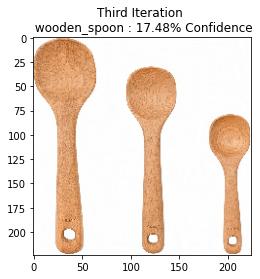

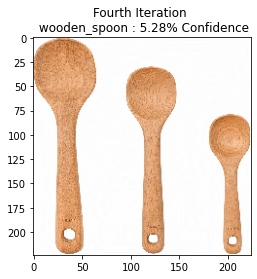

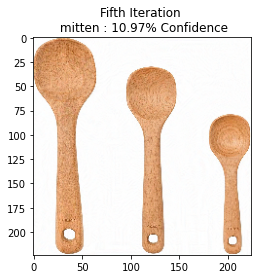

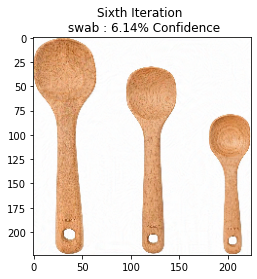

In [50]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

ll_label_index = 840
its = 6
alpha = 2/256

for i in range(its):
  image_probs = pretrained_model.predict(image)

  ll_label = tf.one_hot(ll_label_index, image_probs.shape[-1])
  ll_label = tf.reshape(ll_label, (1, image_probs.shape[-1]))

  perturbations = create_ll_adversarial_pattern(image, ll_label)
  _, pertLabel, pertConfidence = get_imagenet_label(pretrained_model.predict(perturbations))

  descriptions = ['First Iteration', 'Second Iteration', 'Third Iteration', 'Fourth Iteration', 'Fifth Iteration', 'Sixth Iteration', 'Seventh Iteration', 'Eighth Iteration', 'Ninth Iteration', 'Tenth Iteration']

  adv_x = image - alpha*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])
  image = adv_x